In [1]:
import pandas as pd
import datetime
import yfinance as yf

In [2]:
# Retrieve data

In [3]:
def get_ticker_data(symbol, period):
    '''
        Arguments:
            symbol --> Security symbol (str)
            period --> number of years (past x years) (int)
    '''   
    symbol = symbol.upper()
    period = str(period)+'y'
    print(period)
    stocks = yf.Ticker(symbol).history(period=period)    
    df = pd.DataFrame(stocks)
    return df

In [4]:
# Test dataset
data = get_ticker_data('NVDA', 10)
data.columns

10y


Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')

In [5]:
data.reset_index()
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2012-02-09,3.791564,3.812233,3.736448,3.743337,56194400,0.0,0.0
2012-02-10,3.706594,3.720373,3.630809,3.651477,44026800,0.0,0.0
2012-02-13,3.743337,3.757116,3.633104,3.708889,61066800,0.0,0.0
2012-02-14,3.708890,3.761710,3.676739,3.729559,45375600,0.0,0.0
2012-02-15,3.764007,3.881130,3.704297,3.713483,111085600,0.0,0.0
...,...,...,...,...,...,...,...
2022-02-02,257.940002,258.170013,245.529999,252.419998,54341900,0.0,0.0
2022-02-03,244.580002,250.770004,237.800003,239.479996,41017800,0.0,0.0
2022-02-04,239.720001,246.350006,236.320007,243.190002,35432800,0.0,0.0


In [6]:
# Prepare Data

In [9]:
def clean_data(df):
    ind = []
    open_col = []
    high = []
    low = []
    close = []
    vol = []
    
    for i in range(len(df)):
        open_col.append(df['Open'][i])
        high.append(df['High'][i])
        low.append(df['Low'][i])
        close.append(df['Close'][i])
        vol.append(df['Volume'][i])
        
    stocks = pd.DataFrame()
    stocks['Open'] = open_col
    stocks['High'] = high
    stocks['Low'] = low
    stocks['Close'] = close
    stocks['Volume'] = vol
    
    return stocks

In [10]:
data = clean_data(data)

In [11]:
data

,Open,High,Low,Close,Volume
0,3.791564,3.812233,3.736448,3.743337,56194400
1,3.706594,3.720373,3.630809,3.651477,44026800
2,3.743337,3.757116,3.633104,3.708889,61066800
3,3.708890,3.761710,3.676739,3.729559,45375600
4,3.764007,3.881130,3.704297,3.713483,111085600
...,...,...,...,...,...
2512,257.940002,258.170013,245.529999,252.419998,54341900
2513,244.580002,250.770004,237.800003,239.479996,41017800
2514,239.720001,246.350006,236.320007,243.190002,35432800
2515,243.720001,251.820007,242.020004,247.279999,37686800


In [12]:
def normalize_data(df, columns):
    for column in columns:
        temp = []
        min_value = min(df[column])
        max_value = max(df[column])
        for i in range(len(df)):
            temp.append((df[column][i] - min_value) / (max_value - min_value))
        df[column] = temp
    return df
            

In [14]:
data = normalize_data(data, ['Open', 'High', 'Low', 'Close', 'Volume'])

In [15]:
data

,Open,High,Low,Close,Volume
0,0.003416,0.003320,0.003700,0.003412,0.141557
1,0.003161,0.003053,0.003368,0.003135,0.108197
2,0.003271,0.003160,0.003375,0.003308,0.154916
3,0.003168,0.003173,0.003512,0.003371,0.111895
4,0.003333,0.003521,0.003599,0.003322,0.292056
...,...,...,...,...,...
2512,0.767834,0.743256,0.764631,0.754462,0.136478
2513,0.727650,0.721729,0.740305,0.715380,0.099947
2514,0.713033,0.708871,0.735647,0.726585,0.084634
2515,0.725064,0.724783,0.753585,0.738938,0.090814


In [26]:
x = pd.DataFrame()
x['Open'] = data['Open']
x

,Open
0,0.003416
1,0.003161
2,0.003271
3,0.003168
4,0.003333
...,...
2512,0.767834
2513,0.727650
2514,0.713033
2515,0.725064


In [16]:
# Model

In [21]:
# LSTM

In [89]:
import math
import numpy as np
from IPython.display import display
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from keras.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold

In [20]:
def mean_squared_error(outputs, targets):
    squares_sum = 0
    for i in range(len(outputs)):
        squares_sum += (output[i] - targets[i])**2
    mse = float(squares_sum/len(outputs))
    return mse

In [45]:
def prepare_sets(df):
    y = pd.DataFrame()
    y['y'] = df['Close']
    y = y.to_numpy()
    
    x = df.drop(['Close'], axis=1)
    x = x.to_numpy()
    return x, y

In [47]:
x, y = prepare_sets(data)
x

array([[0.00341631, 0.00332029, 0.00370034, 0.14155739],
       [0.00316074, 0.00305307, 0.00336789, 0.10819667],
       [0.00327125, 0.00315996, 0.00337512, 0.15491637],
       ...,
       [0.71303262, 0.70887092, 0.73564728, 0.08463394],
       [0.72506366, 0.72478334, 0.75358533, 0.09081388],
       [0.72467264, 0.72617967, 0.74659893, 0.09962674]])

In [64]:
def split_data(x, y, prediction_period=1, sequence_length=50, test_data_size=0.2):
    test_data_cut = int(test_data_size * len(x)) + sequence_length + 1
    
    # Training data
    X_train = x[0:-prediction_period - test_data_cut]
    y_train = y[prediction_period:-test_data_cut]
    
    # Test data
    X_test = x[-test_data_cut : -prediction_period]
    y_test = y[prediction_period - test_data_cut:]
    
    return X_train, y_train, X_test, y_test

In [65]:
X_train, y_train, X_test, y_test = split_data(x, y)
len(y_test)

553

In [58]:
def prepare_sequences(inputs, outputs, sequence_length=50):
    x = []
    y = []
    
    for i in range(len(inputs)-sequence_length):
        x.append(inputs[i:i+sequence_length])
        y.append(outputs[i+sequence_length])
        
    return np.asarray(x), np.asarray(y)

In [62]:
train_inputs, train_outputs = prepare_sequences(X_train, y_train)
test_inputs, test_outputs = prepare_sequences(X_test, y_test)
len(test_inputs)

503

In [79]:
train_inputs.shape

(1912, 50, 4)

In [73]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

2022-02-10 10:59:15.813889: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-10 10:59:15.813922: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [84]:
def lstm(input_dim, output_dim):
    print(f'{input_dim}, {output_dim}')
    model = Sequential()
    model.add(LSTM(
        input_shape = (None, input_dim),
        units = output_dim,
        return_sequences=True))
    model.add(LSTM(
        100, 
        return_sequences=False))
    model.add(Dense(units=1))
    model.add(Activation('linear'))
    return model

In [85]:
model = lstm(train_inputs.shape[-1], train_inputs.shape[-2])

4, 50


In [91]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [92]:
model.fit(
    train_inputs,
    train_outputs,
    epochs=1,
    validation_split=0.05)

57/57 [==============================] - 6s 55ms/step - loss: 2.0726e-04 - val_loss: 3.8777e-05


In [93]:
predictions = model.predict(test_inputs)

In [94]:
import matplotlib.pyplot as plt

In [117]:
def plot_predictions(predictions, targets):
    figure = plt.figure()
    figure.set_figwidth(18)
    figure.set_figheight(10)
    
    plt.plot(targets, '#00FF00', label='targets')
    plt.plot(predictions, '#0000FF', label='predictions')
    
    plt.show()

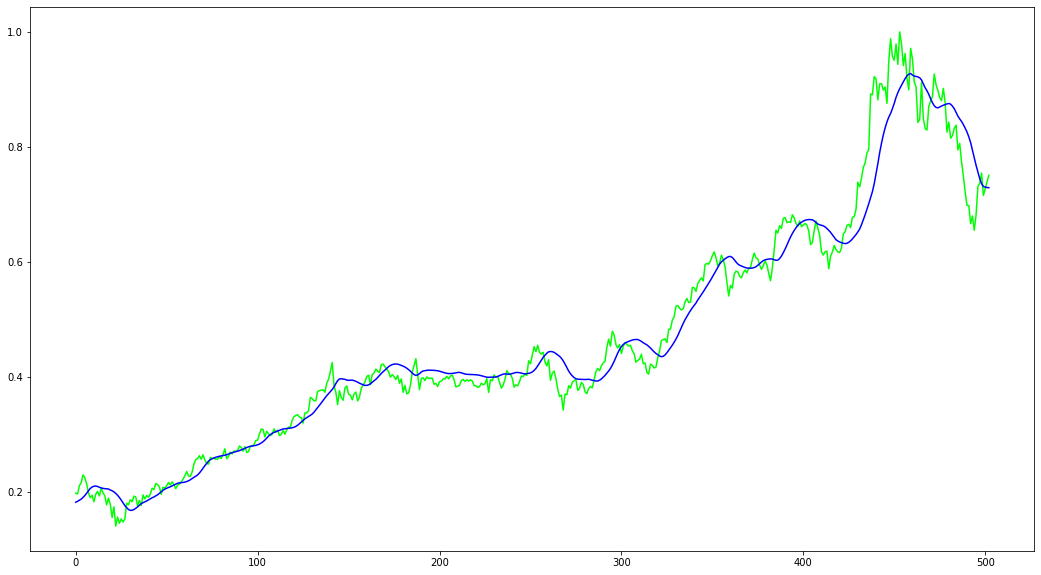

In [118]:
plot_predictions(predictions, test_outputs)

In [119]:
def lstm_updated(input_dim, output_dim):
    model = Sequential()
    model.add(LSTM(
        input_shape=(None, input_dim),
        units=output_dim,
        return_sequences=True))

    model.add(Dropout(0.2))

    model.add(LSTM(
        128,
        return_sequences=False))

    model.add(Dropout(0.2))

    model.add(Dense(
        units=1))
    model.add(Activation('linear'))

    return model

In [120]:
model = lstm_updated(train_inputs.shape[-1], train_inputs.shape[-2])

In [121]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [125]:
model.fit(
    train_inputs,
    train_outputs,
    batch_size=100,
    epochs=5,
    verbose=2,
    validation_split=0.05)

Epoch 1/5
19/19 - 2s - loss: 8.6866e-05 - val_loss: 5.6213e-05 - 2s/epoch - 93ms/step
Epoch 2/5
19/19 - 1s - loss: 7.6374e-05 - val_loss: 4.0965e-05 - 1s/epoch - 74ms/step
Epoch 3/5
19/19 - 2s - loss: 7.3668e-05 - val_loss: 3.6249e-05 - 2s/epoch - 80ms/step
Epoch 4/5
19/19 - 1s - loss: 7.1873e-05 - val_loss: 3.6234e-05 - 1s/epoch - 77ms/step
Epoch 5/5
19/19 - 2s - loss: 6.2990e-05 - val_loss: 3.5906e-05 - 2s/epoch - 80ms/step


In [126]:
predictions = model.predict(test_inputs, batch_size=100)

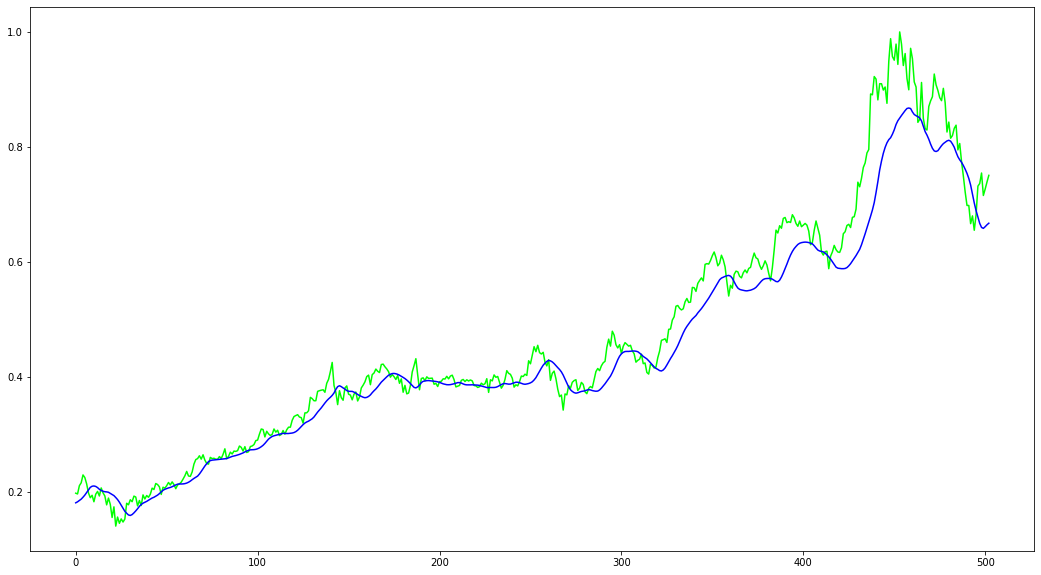

In [127]:
plot_predictions(predictions, test_outputs)